In [1]:
import numpy as np
import torch
import sympy
import torch.nn.functional as F
from backend.utils import *
import pickle
import configparser
import yaml
import torch.optim as optim

This notebook implements different components of the Pde-Net architecture

## SymNet

In [2]:
class SymNet(torch.nn.Module):
    def __init__(self, n_hidden, n_deriv_channel, deriv_channel_names=None):
        '''
        Input:
            n_hidden: Number of hidden Layers to use, this will define the order of non-linerity
            n_deriv_channel:  Number of derivatives eg (u,ux,vx,vxx)
            deriv_channel_names: Names of these channels (will be used to print the learned equation)
            
        '''
        super(SymNet, self).__init__()
        self.n_hidden = n_hidden
        self.n_deriv_channel = n_deriv_channel
        if deriv_channel_names is None:
            deriv_channel_names = list('u_'+str(i) for i in range(self.n_deriv_channel))
        self.deriv_channel_names = deriv_channel_names
        layers = []
        for k in range(n_hidden):
            module = torch.nn.Linear(n_deriv_channel+k,2)
            self.add_module('layer'+str(k), module)
            layers.append(self.__getattr__('layer'+str(k)))
        module = torch.nn.Linear(n_deriv_channel+n_hidden, 1)
        self.add_module('layer_final', module)
        layers.append(self.__getattr__('layer_final'))
        self.layers = tuple(layers)
        
        
    def forward(self, inputs):
        '''
            inputs tensor be of shape: (batch_size x X_dim x n_derivatives)
            output shape: batch_size x X_dim
        '''
        outputs = inputs.type(torch.FloatTensor)
        for k in range(self.n_hidden):
            o = self.layers[k](outputs)
            outputs = torch.cat([outputs,o[...,:1]*o[...,1:]], dim=-1)
        outputs = self.layers[-1](outputs)
        
        return outputs[...,0]
    
    
    
    def _cast2symbol(self,layer):
        weight,bias = layer.weight.data.cpu().numpy(), \
                    layer.bias.data.cpu().numpy()
        weight,bias = sympy.Matrix(weight),sympy.Matrix(bias)
        return weight,bias

    def _sympychop(self,o, calprec):
        for i in range(o.shape[0]):
            cdict = o[i].expand().as_coefficients_dict()  
            o_i = 0
            for k,v in cdict.items():
                if abs(v)>0.1**calprec:
                    o_i = o_i+k*v
            o[i] = o_i
        return o

    def getEquation(self,calprec=6):
        ## assume symnet model
        '''
            Will print the learned equation
        '''
        deriv_channels = sympy.symbols(self.deriv_channel_names)
        deriv_channels = sympy.Matrix([deriv_channels,])
        for i in range(self.n_hidden):
            weight,bias = self._cast2symbol(self.layers[i])
            o = weight*deriv_channels.transpose()+bias
            o = self._sympychop(o, calprec) #ignores very low params terms
            deriv_channels = list(deriv_channels)+[o[0]*o[1],]
            deriv_channels = sympy.Matrix([deriv_channels,])

        weight,bias = self._cast2symbol(self.layers[-1])
        o = (weight*deriv_channels.transpose()+bias)
        o = self._sympychop(o,calprec)

        return o[0]


## Finite Differences 

In [3]:
class FD1D(torch.nn.Module):
    '''
        Finite Differences scheme for 1D dependency
        kernel size: should be greater than or equal to the max_diff_order (otherwise error will be thrown)
        acc_order: acc_order for diff_order
        diff_order: The derivative order
        constarint: Moment matrix constraint "free"(frozen) or "moment"(unfrozen)
        Basically this class initializes one kernel of the specified parameters
    '''
    def __init__(self,dx, kernel_size, diff_order,acc_order,constraint='free'):
        super(FD1D, self).__init__()
        self.dx = dx
        self.kernel_size = kernel_size
        self.diff_order = diff_order
        self.acc_order = acc_order
        self.constraint = constraint
        ## will only be used in case of contraint = 'free'
        if constraint=='free':
            self._kernel = (getKernelTorch(diff_order,acc_order+1,dim=kernel_size,scheme='central')/(dx**diff_order)).type(torch.DoubleTensor)
            
        ##Moment to kernel and vice versa
        if constraint=='moment':
            self.m2k = M2K(kernel_size)
            self.k2m = K2M(kernel_size)
            #define moment matrix
            moment = torch.DoubleTensor(kernel_size).zero_()
            moment[diff_order] = 1
            moment = moment.reshape(1,1,-1)
            self.moment = torch.nn.Parameter(moment) ## now weights will be updated on this
            ##create a mask for gradeint hook
            self.gradient_mask = self._getGradientMask()
            ##register hook to the moment matrix
            self.moment.register_hook(lambda grad: grad.mul_(self.gradient_mask))
        
        
    @property
    def kernel(self):
        if self.constraint == 'moment':
            kernel = self.m2k(self.moment)/(self.dx**self.diff_order)
        else:
            kernel = self._kernel
            
            
        return kernel
    
    def _getGradientMask(self):
        gradient_mask = torch.ones(self.kernel_size,dtype=torch.double)
        order_bank = np.arange(self.kernel_size)
        for j in range(self.diff_order+self.acc_order):
            gradient_mask[order_bank[j]] = 0
        gradient_mask = gradient_mask.reshape(1,1,-1)
        return gradient_mask
        
    def forward(self,inputs):
        '''
            input shape:  batch_size X n_channels(1) X x_dim
            returns: batch_size X n_channels(1) X x_dim (derivative at every point)
        '''
        inp_padded = padInputTorch(inputs,self.diff_order,self.acc_order+1,dim=self.kernel_size) #batch_size x n_channels x (x_dim+padded)
        conv = F.conv1d(inp_padded.type(torch.DoubleTensor),self.kernel)
        return conv
        

## PDE Net

In [5]:
class PdeNet(torch.nn.Module):
    def __init__(self,dt, dx, kernel_size, max_diff_order, n_channel,channel_names,acc_order=2,n_hidden=2,\
                constraint='free'):
        '''
        Note: there will be 1 equation per channel
        Input:
            n_channels: the number of equations to be discovered.
            channel_name: Name of the channels [u,v]
            constraint: free(frozen) or moment(unfrozen)
        '''
        super(PdeNet, self).__init__()
        self.dx = dx
        self.dt = dt
        self.kernel_size = kernel_size
        self.max_diff_order = max_diff_order
        self.n_channel = n_channel
        self.channel_names = channel_names
        self.n_hidden = n_hidden
        self.constraint = constraint
                        
        if not np.iterable(acc_order):
            acc_order = [acc_order,]*(self.max_diff_order+1)
            
        self.acc_order = acc_order
        
        #conv operation
        for i in range(max_diff_order+1):
            kernel = FD1D(dx,kernel_size,i,acc_order[i],constraint=constraint)
            self.add_module('fd'+str(i), kernel) #finite difference of order
            
        #symnet 
        c = channel_names.split(',')
        derivative_channels = []
        for ch in c:
            for k in range(max_diff_order+1):
                derivative_channels.append(ch+'_'+str(k))
        self.derivative_channels = derivative_channels 
        all_symnets = []
        for k in range(self.n_channel):
            self.add_module("symnet_"+str(k),SymNet(n_hidden,len(derivative_channels), deriv_channel_names=derivative_channels))
            all_symnets.append(self.__getattr__('symnet_'+str(k)))
        self.all_symnets = all_symnets
    
    @property
    def fds(self):
        for i in range(self.max_diff_order+1):
            yield self.__getattr__('fd'+str(i))
                
    def multistep(self,inputs,step_num):
        #pass it throught the kernels then the symmnet to 
        '''
        Takes multistep through the whole PDE Net.
        '''
        u = inputs
        for i in range(step_num):
            uadd = self.RightHandItems(u)#will take a dt step from u using the network
            u = u + self.dt*uadd
        return u
    
    def symNetParams(self):
        params = []
        for symnet in self.all_symnets:
            params += list(symnet.parameters())
        return params
    
    def diffParams(self):
        params = []
        for fd in self.fds:
            params += list(fd.parameters())
        return params

    def RightHandItems(self,u):
        
        #convolve the u with the derivative kernals to get the different derivatives 
        #batch_size x n_channels x X_dim
        derives = []
        u_split = u.split(1,dim=1)
        for ch in range(self.n_channel):       
            for i in range(self.max_diff_order+1):
                fd_obj = self.__getattr__('fd'+str(i))
                deriv_channel_ch_order_i = fd_obj(u_split[ch])
                derives.append(deriv_channel_ch_order_i)
            
        U = torch.cat(derives, dim=1) #batch_size x n_derivatives x X_dim 
        #symnet_output = (batch_size x X_dim x n_derivatives)
        u_outs = []
        for symnet in self.all_symnets:
            u_symnet = symnet(U.permute(0,2,1)) #batch_size x X_dim x n_derivatives
            u_out = u_symnet.unsqueeze_(1)
            u_outs.append(u_out)
        u_out = torch.cat(u_outs,axis=1)   
        return u_out
        
        
    def forward(self,inputs,step_num):
        '''
            inputs of shape batch_size x n_channels x X_dim
            step_nums = number of dt blocks to progress by
        '''
        return self.multistep(inputs,step_num)

    

## Loss functions

We will be using 2 losses, one is data loss and the other is symnet loss

In [6]:
def symnetRegularizeLoss(model):
    loss = 0
    s = 1e-2
    for p in model.symNetParams():
        p = p.abs()
        loss = loss+((p<s).to(p)*0.5/s*p**2).sum()+((p>=s).to(p)*(p-s/2)).sum()
    return loss

In [7]:
def momentRegularizeLoss(model):
    loss = 0
    s = 1e-2
    for p in model.diffParams():
        p = p.abs()
        loss = loss+((p<s).to(p)*0.5/s*p**2).sum()+((p>=s).to(p)*(p-s/2)).sum()

    return loss

In [8]:
#global names are all the parameters
def modelLoss(model,u_obs,config,block):
    '''
        Returns the loss value for so that it can be given to an optimizer
        Inputs:
            u_obs (batch_size x n_channels x X_dim)
            blocks is stepnum
    '''
    sparsity = config['sparsity']
    momentsparsity = config['momentsparsity']
    
    
    if block==0: #warmup
        sparsity = 0
    step_num = block if block>=1 else 1
    dt = config['dt']
    data_loss = 0
    symnet_loss = symnetRegularizeLoss(model)
    moment_loss = momentRegularizeLoss(model)
    ut = u_obs[0]
    mse_loss = torch.nn.MSELoss()
    for steps in range(1,step_num+1):
        ut_next_predicted = model(ut,step_num=1) #take one step from this point
        data_loss += (mse_loss(ut_next_predicted,u_obs[steps])/dt**2)/step_num
        ut = ut_next_predicted

    loss = data_loss+stepnum*sparsity*symnet_loss+stepnum*momentsparsity*moment_loss
    if torch.isnan(loss):
        raise "Loss Nan"
        loss = (torch.ones(1,requires_grad=True)/torch.zeros(1)).to(loss)
    return loss,data_loss,symnet_loss,moment_loss


## Utility Functions

In [8]:
##modify channel names and length
def setenv(config): #return model and datamodel
    model = PdeNet(config['dt'],config['dx'],config['kernel_size'],config['max_diff_order']\
                   ,config['n_channels'],config['channel_names'],config['acc_order'],config['n_hidden_layers'],config['constraint'])
    
    #data model 
    if 'Diffusion' in config['dataname']:
    #data model 
        data_model = DiffusionDataTrign(config['dataname'],config['Nt'],\
                                   config['dt'],config['dx'],config['viscosity'],batch_size=config['batch_size'],\
                                  time_scheme=config['data_timescheme'],acc_order=config['acc_order']+1)        
    if 'Burgers' in config['dataname']:
        data_model = BurgersEqnTrign(config['dataname'],config['Nt'],\
                               config['dt'],config['dx'],config['viscosity'],batch_size=config['batch_size'],\
                              time_scheme=config['data_timescheme'],acc_order=config['acc_order']+1)
    
    if 'Cross' in config['dataname']:
        data_model = CrossAdvection(config['dataname'],config['Nt'],\
                               config['dt'],config['dx'],config['viscosity'],config['batch_size'],\
                              time_scheme=config['data_timescheme'],acc_order=config['acc_order']+1)
        
    if 'Energy' in config['dataname']:
        data_model = EnergyExchange(config['dataname'],config['Nt'],\
                               config['dt'],config['dx'],config['viscosity'],config['batch_size'],\
                              time_scheme=config['data_timescheme'],acc_order=config['acc_order']+1)
        
    if 'Advanced' in config['dataname']:
        data_model = EnergyExchangeAdvan(config['dataname'],config['Nt'],\
                               config['dt'],config['dx'],config['viscosity'],config['batch_size'],\
                              time_scheme=config['data_timescheme'],acc_order=config['acc_order']+1)
        
    #possible some callbacks
    callbacks = None
    return model,data_model,callbacks

# Training

## Diffusion Eqn

In [71]:
with open("config_diffusion.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [72]:
config

{'name': 'Diffusion Eqn',
 'dt': 0.01,
 'dx': 0.1,
 'blocks': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'kernel_size': 5,
 'max_diff_order': 2,
 'acc_order': 1,
 'n_hidden_layers': 2,
 'dataname': 'Diffusion',
 'viscosity': 0.1,
 'batch_size': 32,
 'channel_names': 'u',
 'data_timescheme': 'rk4',
 'data_dir': '/sdsd/dsds/sdsd',
 'Nt': 100,
 'Nx': 32,
 'sigma': 1,
 'sparsity': 0.005,
 'momentsparsity': 0.001,
 'epochs': 500,
 'results_dir': '/comet/results/',
 'seed': -1,
 'learning_rate': 0.005,
 'constraint': 'moment'}

In [73]:
blocks = config['blocks']
dt = config['dt']
dx = config['dx']
epochs = config['epochs']
lr = config['learning_rate']

In [26]:
model,data_model,callbacks = setenv(config)

In [27]:
##optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [147]:
for block in blocks:
    print('[PRINT] block:',block)
    if block==0:
        print('[PRINT] Warmum Stage')
    stepnum = block if block>=1 else 1
    #get the data at this time #shape [block,batch,channel,X_dim]
    u_obs = data_model.data(stepnum+1) #np array of stepnum elements
    for epoch in range(epochs):
        #zero grad
        optimizer.zero_grad()
        #forward
        loss,data_loss,syment_reg,moment_loss = modelLoss(model,u_obs,config,block)
        loss.backward()
        optimizer.step()
        if epoch%10==0:
            print("[PRINT] Epoch: %d, Loss: %.3f, Data Loss: %.3f, Symnet Regularize: %.3f, Moment Regularize: %.3f "\
                  % (epoch,loss,\
                      data_loss,syment_reg,\
                      moment_loss))

    


[PRINT] block: 0
[PRINT] Warmum Stage


TypeError: expected np.ndarray (got list)

In [29]:
model.symnet.getEquation(calprec=2)

0.0977183*u_2

In [30]:
torch.save(model.state_dict(),"Diffusion_model_moment.pth")

## Burger's Equation

In [31]:
with open("config_burgers.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [32]:
config

{'name': 'Burgers Eqn',
 'dt': 0.01,
 'dx': 0.1,
 'blocks': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'kernel_size': 5,
 'max_diff_order': 2,
 'acc_order': 2,
 'n_hidden_layers': 2,
 'dataname': 'Diffusion',
 'viscosity': 0.1,
 'batch_size': 32,
 'channel_names': 'u',
 'data_timescheme': 'rk4',
 'data_dir': '/sdsd/dsds/sdsd',
 'Nt': 100,
 'Nx': 32,
 'sigma': 1,
 'sparsity': 0.005,
 'momentsparsity': 0.001,
 'epochs': 500,
 'results_dir': '/comet/results/',
 'seed': -1,
 'learning_rate': 0.005,
 'constraint': 'moment'}

In [33]:
model,data_model,callbacks = setenv(config)

In [34]:
##optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [36]:
for block in blocks:
    print('[PRINT] block:',block)
    if block==0:
        print('[PRINT] Warmum Stage')
    stepnum = block if block>=1 else 1
    #get the data at this time #shape [block,batch,channel,X_dim]
    u_obs = data_model.data(stepnum+1) #np array of stepnum elements
    for epoch in range(epochs):
        #zero grad
        optimizer.zero_grad()
        #forward
        loss,data_loss,syment_reg,moment_loss = modelLoss(model,u_obs,config,block)
        loss.backward()
        optimizer.step()
        if epoch%10==0:
            print("[PRINT] Epoch: %d, Loss: %.3f, Data Loss: %.3f, Symnet Regularize: %.3f, Moment Regularize: %.3f "\
                  % (epoch,loss,\
                      data_loss,syment_reg,\
                      moment_loss))

    


[PRINT] block: 0
[PRINT] Warmum Stage
[PRINT] Epoch: 0, Loss: 24.380, Data Loss: 24.377, Symnet Regularize: 4.892, Moment Regularize: 2.985 
[PRINT] Epoch: 10, Loss: 19.607, Data Loss: 19.604, Symnet Regularize: 4.596, Moment Regularize: 3.245 
[PRINT] Epoch: 20, Loss: 16.844, Data Loss: 16.840, Symnet Regularize: 4.512, Moment Regularize: 3.495 
[PRINT] Epoch: 30, Loss: 14.867, Data Loss: 14.863, Symnet Regularize: 4.832, Moment Regularize: 3.662 
[PRINT] Epoch: 40, Loss: 13.648, Data Loss: 13.645, Symnet Regularize: 5.200, Moment Regularize: 3.730 
[PRINT] Epoch: 50, Loss: 12.418, Data Loss: 12.414, Symnet Regularize: 5.425, Moment Regularize: 3.799 
[PRINT] Epoch: 60, Loss: 11.094, Data Loss: 11.091, Symnet Regularize: 5.809, Moment Regularize: 3.816 
[PRINT] Epoch: 70, Loss: 9.966, Data Loss: 9.962, Symnet Regularize: 6.322, Moment Regularize: 3.786 
[PRINT] Epoch: 80, Loss: 8.904, Data Loss: 8.900, Symnet Regularize: 6.707, Moment Regularize: 3.725 
[PRINT] Epoch: 90, Loss: 7.695,

[PRINT] Epoch: 300, Loss: 0.065, Data Loss: 0.021, Symnet Regularize: 8.052, Moment Regularize: 3.567 
[PRINT] Epoch: 310, Loss: 0.065, Data Loss: 0.021, Symnet Regularize: 8.046, Moment Regularize: 3.570 
[PRINT] Epoch: 320, Loss: 0.065, Data Loss: 0.021, Symnet Regularize: 8.039, Moment Regularize: 3.572 
[PRINT] Epoch: 330, Loss: 0.065, Data Loss: 0.021, Symnet Regularize: 8.033, Moment Regularize: 3.575 
[PRINT] Epoch: 340, Loss: 0.065, Data Loss: 0.021, Symnet Regularize: 8.026, Moment Regularize: 3.577 
[PRINT] Epoch: 350, Loss: 0.064, Data Loss: 0.021, Symnet Regularize: 8.019, Moment Regularize: 3.579 
[PRINT] Epoch: 360, Loss: 0.064, Data Loss: 0.021, Symnet Regularize: 8.013, Moment Regularize: 3.581 
[PRINT] Epoch: 370, Loss: 0.064, Data Loss: 0.021, Symnet Regularize: 8.006, Moment Regularize: 3.584 
[PRINT] Epoch: 380, Loss: 0.064, Data Loss: 0.020, Symnet Regularize: 7.999, Moment Regularize: 3.586 
[PRINT] Epoch: 390, Loss: 0.064, Data Loss: 0.020, Symnet Regularize: 7.9

[PRINT] Epoch: 100, Loss: 0.154, Data Loss: 0.035, Symnet Regularize: 7.187, Moment Regularize: 3.878 
[PRINT] Epoch: 110, Loss: 0.153, Data Loss: 0.034, Symnet Regularize: 7.168, Moment Regularize: 3.879 
[PRINT] Epoch: 120, Loss: 0.152, Data Loss: 0.033, Symnet Regularize: 7.148, Moment Regularize: 3.879 
[PRINT] Epoch: 130, Loss: 0.150, Data Loss: 0.032, Symnet Regularize: 7.130, Moment Regularize: 3.878 
[PRINT] Epoch: 140, Loss: 0.149, Data Loss: 0.031, Symnet Regularize: 7.112, Moment Regularize: 3.878 
[PRINT] Epoch: 150, Loss: 0.148, Data Loss: 0.030, Symnet Regularize: 7.095, Moment Regularize: 3.876 
[PRINT] Epoch: 160, Loss: 0.147, Data Loss: 0.029, Symnet Regularize: 7.078, Moment Regularize: 3.874 
[PRINT] Epoch: 170, Loss: 0.145, Data Loss: 0.028, Symnet Regularize: 7.060, Moment Regularize: 3.872 
[PRINT] Epoch: 180, Loss: 0.144, Data Loss: 0.027, Symnet Regularize: 7.041, Moment Regularize: 3.870 
[PRINT] Epoch: 190, Loss: 0.143, Data Loss: 0.026, Symnet Regularize: 7.0

[PRINT] Epoch: 400, Loss: 0.172, Data Loss: 0.025, Symnet Regularize: 6.569, Moment Regularize: 3.847 
[PRINT] Epoch: 410, Loss: 0.172, Data Loss: 0.025, Symnet Regularize: 6.565, Moment Regularize: 3.847 
[PRINT] Epoch: 420, Loss: 0.172, Data Loss: 0.025, Symnet Regularize: 6.560, Moment Regularize: 3.846 
[PRINT] Epoch: 430, Loss: 0.172, Data Loss: 0.025, Symnet Regularize: 6.556, Moment Regularize: 3.845 
[PRINT] Epoch: 440, Loss: 0.172, Data Loss: 0.025, Symnet Regularize: 6.552, Moment Regularize: 3.845 
[PRINT] Epoch: 450, Loss: 0.172, Data Loss: 0.025, Symnet Regularize: 6.548, Moment Regularize: 3.844 
[PRINT] Epoch: 460, Loss: 0.172, Data Loss: 0.025, Symnet Regularize: 6.543, Moment Regularize: 3.843 
[PRINT] Epoch: 470, Loss: 0.171, Data Loss: 0.025, Symnet Regularize: 6.539, Moment Regularize: 3.843 
[PRINT] Epoch: 480, Loss: 0.171, Data Loss: 0.025, Symnet Regularize: 6.534, Moment Regularize: 3.842 
[PRINT] Epoch: 490, Loss: 0.171, Data Loss: 0.025, Symnet Regularize: 6.5

[PRINT] Epoch: 200, Loss: 0.270, Data Loss: 0.061, Symnet Regularize: 6.165, Moment Regularize: 4.008 
[PRINT] Epoch: 210, Loss: 0.270, Data Loss: 0.061, Symnet Regularize: 6.163, Moment Regularize: 4.004 
[PRINT] Epoch: 220, Loss: 0.270, Data Loss: 0.061, Symnet Regularize: 6.162, Moment Regularize: 4.000 
[PRINT] Epoch: 230, Loss: 0.270, Data Loss: 0.061, Symnet Regularize: 6.160, Moment Regularize: 3.996 
[PRINT] Epoch: 240, Loss: 0.269, Data Loss: 0.061, Symnet Regularize: 6.158, Moment Regularize: 3.993 
[PRINT] Epoch: 250, Loss: 0.269, Data Loss: 0.061, Symnet Regularize: 6.156, Moment Regularize: 3.990 
[PRINT] Epoch: 260, Loss: 0.269, Data Loss: 0.061, Symnet Regularize: 6.154, Moment Regularize: 3.987 
[PRINT] Epoch: 270, Loss: 0.269, Data Loss: 0.061, Symnet Regularize: 6.151, Moment Regularize: 3.984 
[PRINT] Epoch: 280, Loss: 0.269, Data Loss: 0.061, Symnet Regularize: 6.149, Moment Regularize: 3.982 
[PRINT] Epoch: 290, Loss: 0.269, Data Loss: 0.061, Symnet Regularize: 6.1

[PRINT] block: 8
[PRINT] Epoch: 0, Loss: 0.413, Data Loss: 0.144, Symnet Regularize: 5.925, Moment Regularize: 4.000 
[PRINT] Epoch: 10, Loss: 6.425, Data Loss: 6.160, Symnet Regularize: 5.848, Moment Regularize: 3.956 
[PRINT] Epoch: 20, Loss: 1.763, Data Loss: 1.494, Symnet Regularize: 5.955, Moment Regularize: 3.833 
[PRINT] Epoch: 30, Loss: 1.215, Data Loss: 0.948, Symnet Regularize: 5.919, Moment Regularize: 3.794 
[PRINT] Epoch: 40, Loss: 1.063, Data Loss: 0.795, Symnet Regularize: 5.924, Moment Regularize: 3.839 
[PRINT] Epoch: 50, Loss: 0.944, Data Loss: 0.675, Symnet Regularize: 5.943, Moment Regularize: 3.881 
[PRINT] Epoch: 60, Loss: 0.897, Data Loss: 0.628, Symnet Regularize: 5.937, Moment Regularize: 3.940 
[PRINT] Epoch: 70, Loss: 0.854, Data Loss: 0.586, Symnet Regularize: 5.913, Moment Regularize: 4.004 
[PRINT] Epoch: 80, Loss: 0.809, Data Loss: 0.540, Symnet Regularize: 5.899, Moment Regularize: 4.066 
[PRINT] Epoch: 90, Loss: 0.749, Data Loss: 0.480, Symnet Regulariz

[PRINT] Epoch: 300, Loss: 0.531, Data Loss: 0.235, Symnet Regularize: 5.759, Moment Regularize: 4.102 
[PRINT] Epoch: 310, Loss: 0.544, Data Loss: 0.248, Symnet Regularize: 5.755, Moment Regularize: 4.105 
[PRINT] Epoch: 320, Loss: 0.513, Data Loss: 0.217, Symnet Regularize: 5.752, Moment Regularize: 4.106 
[PRINT] Epoch: 330, Loss: 0.509, Data Loss: 0.214, Symnet Regularize: 5.751, Moment Regularize: 4.107 
[PRINT] Epoch: 340, Loss: 0.509, Data Loss: 0.213, Symnet Regularize: 5.749, Moment Regularize: 4.108 
[PRINT] Epoch: 350, Loss: 0.507, Data Loss: 0.211, Symnet Regularize: 5.746, Moment Regularize: 4.107 
[PRINT] Epoch: 360, Loss: 0.506, Data Loss: 0.211, Symnet Regularize: 5.744, Moment Regularize: 4.107 
[PRINT] Epoch: 370, Loss: 0.506, Data Loss: 0.211, Symnet Regularize: 5.741, Moment Regularize: 4.106 
[PRINT] Epoch: 380, Loss: 0.506, Data Loss: 0.211, Symnet Regularize: 5.738, Moment Regularize: 4.106 
[PRINT] Epoch: 390, Loss: 0.506, Data Loss: 0.211, Symnet Regularize: 5.7

In [42]:
model.symnet.getEquation(calprec=1)

-0.972136*u_0*u_1 + 0.103841*u_2

## To Incorporate Channels

## Cross-Advection

In [34]:
with open("config_cross_advection.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [35]:
config

{'name': 'Cross-Advection',
 'dt': 0.01,
 'dx': 0.1,
 'blocks': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'kernel_size': 5,
 'max_diff_order': 2,
 'acc_order': 1,
 'n_hidden_layers': 2,
 'n_channels': 2,
 'dataname': 'Cross-Advection',
 'viscosity': 0.1,
 'batch_size': 32,
 'channel_names': 'u,v',
 'data_timescheme': 'rk4',
 'data_dir': '/sdsd/dsds/sdsd',
 'Nt': 100,
 'Nx': 32,
 'sigma': 1,
 'sparsity': 0.005,
 'momentsparsity': 0.001,
 'epochs': 500,
 'results_dir': '/comet/results/',
 'seed': -1,
 'learning_rate': 0.01,
 'constraint': 'moment'}

In [36]:
blocks = config['blocks']
dt = config['dt']
dx = config['dx']
epochs = config['epochs']
lr = config['learning_rate']

In [37]:
model,data_model,callbacks = setenv(config)

In [38]:
##optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [39]:
for block in blocks:
    print('[PRINT] block:',block)
    if block==0:
        print('[PRINT] Warmum Stage')
    stepnum = block if block>=1 else 1
    #get the data at this time #shape [block,batch,channel,X_dim]
    u_obs = data_model.data(stepnum+1) #np array of stepnum elements
    for epoch in range(epochs):
        #zero grad
        optimizer.zero_grad()
        #forward
        loss,data_loss,syment_reg,moment_loss = modelLoss(model,u_obs,config,block)
        loss.backward()
        optimizer.step()
        if epoch%10==0:
            print("[PRINT] Epoch: %d, Loss: %.3f, Data Loss: %.3f, Symnet Regularize: %.3f, Moment Regularize: %.3f "\
                  % (epoch,loss,\
                      data_loss,syment_reg,\
                      moment_loss))

    


[PRINT] block: 0
[PRINT] Warmum Stage
[PRINT] Epoch: 0, Loss: 56.041, Data Loss: 56.038, Symnet Regularize: 15.524, Moment Regularize: 2.985 
[PRINT] Epoch: 10, Loss: 14.310, Data Loss: 14.306, Symnet Regularize: 13.799, Moment Regularize: 3.441 
[PRINT] Epoch: 20, Loss: 11.262, Data Loss: 11.258, Symnet Regularize: 13.594, Moment Regularize: 3.565 
[PRINT] Epoch: 30, Loss: 10.561, Data Loss: 10.558, Symnet Regularize: 14.246, Moment Regularize: 3.587 
[PRINT] Epoch: 40, Loss: 9.977, Data Loss: 9.974, Symnet Regularize: 15.178, Moment Regularize: 3.541 
[PRINT] Epoch: 50, Loss: 9.188, Data Loss: 9.184, Symnet Regularize: 16.036, Moment Regularize: 3.527 
[PRINT] Epoch: 60, Loss: 8.302, Data Loss: 8.298, Symnet Regularize: 16.992, Moment Regularize: 3.610 
[PRINT] Epoch: 70, Loss: 7.349, Data Loss: 7.345, Symnet Regularize: 17.940, Moment Regularize: 3.757 
[PRINT] Epoch: 80, Loss: 6.277, Data Loss: 6.273, Symnet Regularize: 19.071, Moment Regularize: 3.891 
[PRINT] Epoch: 90, Loss: 5.0

[PRINT] Epoch: 290, Loss: 0.108, Data Loss: 0.013, Symnet Regularize: 18.149, Moment Regularize: 3.467 
[PRINT] Epoch: 300, Loss: 0.107, Data Loss: 0.013, Symnet Regularize: 18.097, Moment Regularize: 3.463 
[PRINT] Epoch: 310, Loss: 0.107, Data Loss: 0.013, Symnet Regularize: 18.045, Moment Regularize: 3.459 
[PRINT] Epoch: 320, Loss: 0.107, Data Loss: 0.013, Symnet Regularize: 17.994, Moment Regularize: 3.455 
[PRINT] Epoch: 330, Loss: 0.106, Data Loss: 0.013, Symnet Regularize: 17.942, Moment Regularize: 3.450 
[PRINT] Epoch: 340, Loss: 0.106, Data Loss: 0.013, Symnet Regularize: 17.891, Moment Regularize: 3.446 
[PRINT] Epoch: 350, Loss: 0.106, Data Loss: 0.013, Symnet Regularize: 17.840, Moment Regularize: 3.442 
[PRINT] Epoch: 360, Loss: 0.105, Data Loss: 0.013, Symnet Regularize: 17.789, Moment Regularize: 3.438 
[PRINT] Epoch: 370, Loss: 0.105, Data Loss: 0.013, Symnet Regularize: 17.738, Moment Regularize: 3.433 
[PRINT] Epoch: 380, Loss: 0.105, Data Loss: 0.013, Symnet Regula

[PRINT] Epoch: 80, Loss: 0.270, Data Loss: 0.054, Symnet Regularize: 13.729, Moment Regularize: 3.241 
[PRINT] Epoch: 90, Loss: 0.268, Data Loss: 0.054, Symnet Regularize: 13.641, Moment Regularize: 3.240 
[PRINT] Epoch: 100, Loss: 0.267, Data Loss: 0.054, Symnet Regularize: 13.550, Moment Regularize: 3.240 
[PRINT] Epoch: 110, Loss: 0.266, Data Loss: 0.054, Symnet Regularize: 13.455, Moment Regularize: 3.240 
[PRINT] Epoch: 120, Loss: 0.264, Data Loss: 0.054, Symnet Regularize: 13.357, Moment Regularize: 3.241 
[PRINT] Epoch: 130, Loss: 0.263, Data Loss: 0.054, Symnet Regularize: 13.256, Moment Regularize: 3.241 
[PRINT] Epoch: 140, Loss: 0.261, Data Loss: 0.054, Symnet Regularize: 13.153, Moment Regularize: 3.241 
[PRINT] Epoch: 150, Loss: 0.260, Data Loss: 0.055, Symnet Regularize: 13.046, Moment Regularize: 3.241 
[PRINT] Epoch: 160, Loss: 0.258, Data Loss: 0.055, Symnet Regularize: 12.938, Moment Regularize: 3.241 
[PRINT] Epoch: 170, Loss: 0.257, Data Loss: 0.055, Symnet Regulari

[PRINT] Epoch: 380, Loss: 0.265, Data Loss: 0.090, Symnet Regularize: 8.125, Moment Regularize: 3.242 
[PRINT] Epoch: 390, Loss: 0.264, Data Loss: 0.090, Symnet Regularize: 8.066, Moment Regularize: 3.243 
[PRINT] Epoch: 400, Loss: 0.263, Data Loss: 0.090, Symnet Regularize: 8.007, Moment Regularize: 3.243 
[PRINT] Epoch: 410, Loss: 0.262, Data Loss: 0.090, Symnet Regularize: 7.947, Moment Regularize: 3.243 
[PRINT] Epoch: 420, Loss: 0.261, Data Loss: 0.090, Symnet Regularize: 7.887, Moment Regularize: 3.243 
[PRINT] Epoch: 430, Loss: 0.260, Data Loss: 0.090, Symnet Regularize: 7.829, Moment Regularize: 3.243 
[PRINT] Epoch: 440, Loss: 0.258, Data Loss: 0.090, Symnet Regularize: 7.772, Moment Regularize: 3.243 
[PRINT] Epoch: 450, Loss: 0.257, Data Loss: 0.090, Symnet Regularize: 7.716, Moment Regularize: 3.243 
[PRINT] Epoch: 460, Loss: 0.256, Data Loss: 0.090, Symnet Regularize: 7.663, Moment Regularize: 3.243 
[PRINT] Epoch: 470, Loss: 0.255, Data Loss: 0.090, Symnet Regularize: 7.6

[PRINT] Epoch: 180, Loss: 0.403, Data Loss: 0.179, Symnet Regularize: 6.807, Moment Regularize: 3.289 
[PRINT] Epoch: 190, Loss: 0.403, Data Loss: 0.179, Symnet Regularize: 6.804, Moment Regularize: 3.290 
[PRINT] Epoch: 200, Loss: 0.403, Data Loss: 0.179, Symnet Regularize: 6.801, Moment Regularize: 3.290 
[PRINT] Epoch: 210, Loss: 0.403, Data Loss: 0.179, Symnet Regularize: 6.797, Moment Regularize: 3.290 
[PRINT] Epoch: 220, Loss: 0.403, Data Loss: 0.179, Symnet Regularize: 6.794, Moment Regularize: 3.290 
[PRINT] Epoch: 230, Loss: 0.402, Data Loss: 0.179, Symnet Regularize: 6.791, Moment Regularize: 3.290 
[PRINT] Epoch: 240, Loss: 0.402, Data Loss: 0.179, Symnet Regularize: 6.787, Moment Regularize: 3.291 
[PRINT] Epoch: 250, Loss: 0.402, Data Loss: 0.179, Symnet Regularize: 6.784, Moment Regularize: 3.291 
[PRINT] Epoch: 260, Loss: 0.402, Data Loss: 0.179, Symnet Regularize: 6.781, Moment Regularize: 3.291 
[PRINT] Epoch: 270, Loss: 0.402, Data Loss: 0.179, Symnet Regularize: 6.7

KeyboardInterrupt: 

In [30]:
for symnet in model.all_symnets:
    symnet.getEquation(calprec=2)

In [31]:
model.all_symnets[0].getEquation(calprec=1)

-0.971706*u_1*v_0 + 0.106704*u_2

In [32]:
model.all_symnets[1].getEquation(calprec=1)

-0.976846*u_0*v_1 + 0.10752*v_2

In [33]:
torch.save(model.state_dict(),"Cross_Adv_frozen.pth")

In [40]:
for symnet in model.all_symnets:
    symnet.getEquation(calprec=2)

In [41]:
model.all_symnets[0].getEquation(calprec=1)

-0.986716*u_1*v_0 + 0.106192*u_2

In [42]:
model.all_symnets[1].getEquation(calprec=1)

-0.985997*u_0*v_1 + 0.106968*v_2

In [43]:
torch.save(model.state_dict(),"Cross_Adv_constraint.pth")

## Energy

In [87]:
with open("config_energy_exchange.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [88]:
config

{'name': 'Energy-Exchange',
 'dt': 0.0001,
 'dx': 0.1,
 'blocks': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'kernel_size': 5,
 'max_diff_order': 2,
 'acc_order': 1,
 'n_hidden_layers': 2,
 'n_channels': 2,
 'dataname': 'Energy-Exchange',
 'viscosity': 0.1,
 'batch_size': 32,
 'channel_names': 'u,v',
 'data_timescheme': 'rk4',
 'data_dir': '/sdsd/dsds/sdsd',
 'Nt': 1000,
 'Nx': 32,
 'sigma': 1,
 'sparsity': 0.005,
 'momentsparsity': 0.001,
 'epochs': 500,
 'results_dir': '/comet/results/',
 'seed': -1,
 'learning_rate': 0.02,
 'constraint': 'moment'}

In [89]:
blocks = config['blocks']
dt = config['dt']
dx = config['dx']
epochs = config['epochs']
lr = config['learning_rate']

In [90]:
model,data_model,callbacks = setenv(config)

In [48]:
##optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [49]:
for block in blocks:
    print('[PRINT] block:',block)
    if block==0:
        print('[PRINT] Warmum Stage')
    stepnum = block if block>=1 else 1
    #get the data at this time #shape [block,batch,channel,X_dim]
    u_obs = data_model.data(stepnum+1) #np array of stepnum elements
    for epoch in range(epochs):
        #zero grad
        optimizer.zero_grad()
        #forward
        loss,data_loss,syment_reg,moment_loss = modelLoss(model,u_obs,config,block)
        loss.backward()
        optimizer.step()
        if epoch%10==0:
            print("[PRINT] Epoch: %d, Loss: %.3f, Data Loss: %.3f, Symnet Regularize: %.3f, Moment Regularize: %.3f "\
                  % (epoch,loss,\
                      data_loss,syment_reg,\
                      moment_loss))

    


[PRINT] block: 0
[PRINT] Warmum Stage
[PRINT] Epoch: 0, Loss: 36.997, Data Loss: 36.997, Symnet Regularize: 14.248, Moment Regularize: 0.000 
[PRINT] Epoch: 10, Loss: 5.973, Data Loss: 5.973, Symnet Regularize: 11.339, Moment Regularize: 0.000 
[PRINT] Epoch: 20, Loss: 4.559, Data Loss: 4.559, Symnet Regularize: 11.667, Moment Regularize: 0.000 
[PRINT] Epoch: 30, Loss: 4.129, Data Loss: 4.129, Symnet Regularize: 12.679, Moment Regularize: 0.000 
[PRINT] Epoch: 40, Loss: 3.331, Data Loss: 3.331, Symnet Regularize: 14.228, Moment Regularize: 0.000 
[PRINT] Epoch: 50, Loss: 2.399, Data Loss: 2.399, Symnet Regularize: 16.089, Moment Regularize: 0.000 
[PRINT] Epoch: 60, Loss: 1.588, Data Loss: 1.588, Symnet Regularize: 17.154, Moment Regularize: 0.000 
[PRINT] Epoch: 70, Loss: 0.973, Data Loss: 0.973, Symnet Regularize: 17.766, Moment Regularize: 0.000 
[PRINT] Epoch: 80, Loss: 0.413, Data Loss: 0.413, Symnet Regularize: 17.821, Moment Regularize: 0.000 
[PRINT] Epoch: 90, Loss: 0.136, Da

[PRINT] Epoch: 300, Loss: 0.064, Data Loss: 0.001, Symnet Regularize: 12.711, Moment Regularize: 0.000 
[PRINT] Epoch: 310, Loss: 0.064, Data Loss: 0.001, Symnet Regularize: 12.661, Moment Regularize: 0.000 
[PRINT] Epoch: 320, Loss: 0.064, Data Loss: 0.001, Symnet Regularize: 12.613, Moment Regularize: 0.000 
[PRINT] Epoch: 330, Loss: 0.064, Data Loss: 0.001, Symnet Regularize: 12.566, Moment Regularize: 0.000 
[PRINT] Epoch: 340, Loss: 0.063, Data Loss: 0.001, Symnet Regularize: 12.519, Moment Regularize: 0.000 
[PRINT] Epoch: 350, Loss: 0.063, Data Loss: 0.001, Symnet Regularize: 12.471, Moment Regularize: 0.000 
[PRINT] Epoch: 360, Loss: 0.063, Data Loss: 0.001, Symnet Regularize: 12.424, Moment Regularize: 0.000 
[PRINT] Epoch: 370, Loss: 0.063, Data Loss: 0.001, Symnet Regularize: 12.376, Moment Regularize: 0.000 
[PRINT] Epoch: 380, Loss: 0.063, Data Loss: 0.001, Symnet Regularize: 12.329, Moment Regularize: 0.000 
[PRINT] Epoch: 390, Loss: 0.062, Data Loss: 0.001, Symnet Regula

[PRINT] Epoch: 100, Loss: 0.108, Data Loss: 0.004, Symnet Regularize: 6.921, Moment Regularize: 0.000 
[PRINT] Epoch: 110, Loss: 0.107, Data Loss: 0.004, Symnet Regularize: 6.909, Moment Regularize: 0.000 
[PRINT] Epoch: 120, Loss: 0.107, Data Loss: 0.004, Symnet Regularize: 6.897, Moment Regularize: 0.000 
[PRINT] Epoch: 130, Loss: 0.107, Data Loss: 0.004, Symnet Regularize: 6.886, Moment Regularize: 0.000 
[PRINT] Epoch: 140, Loss: 0.107, Data Loss: 0.004, Symnet Regularize: 6.874, Moment Regularize: 0.000 
[PRINT] Epoch: 150, Loss: 0.107, Data Loss: 0.004, Symnet Regularize: 6.862, Moment Regularize: 0.000 
[PRINT] Epoch: 160, Loss: 0.107, Data Loss: 0.004, Symnet Regularize: 6.851, Moment Regularize: 0.000 
[PRINT] Epoch: 170, Loss: 0.106, Data Loss: 0.004, Symnet Regularize: 6.839, Moment Regularize: 0.000 
[PRINT] Epoch: 180, Loss: 0.106, Data Loss: 0.004, Symnet Regularize: 6.828, Moment Regularize: 0.000 
[PRINT] Epoch: 190, Loss: 0.106, Data Loss: 0.004, Symnet Regularize: 6.8

[PRINT] Epoch: 400, Loss: 0.131, Data Loss: 0.006, Symnet Regularize: 6.257, Moment Regularize: 0.000 
[PRINT] Epoch: 410, Loss: 0.131, Data Loss: 0.006, Symnet Regularize: 6.255, Moment Regularize: 0.000 
[PRINT] Epoch: 420, Loss: 0.131, Data Loss: 0.006, Symnet Regularize: 6.253, Moment Regularize: 0.000 
[PRINT] Epoch: 430, Loss: 0.131, Data Loss: 0.006, Symnet Regularize: 6.250, Moment Regularize: 0.000 
[PRINT] Epoch: 440, Loss: 0.131, Data Loss: 0.006, Symnet Regularize: 6.248, Moment Regularize: 0.000 
[PRINT] Epoch: 450, Loss: 0.131, Data Loss: 0.006, Symnet Regularize: 6.246, Moment Regularize: 0.000 
[PRINT] Epoch: 460, Loss: 0.131, Data Loss: 0.006, Symnet Regularize: 6.244, Moment Regularize: 0.000 
[PRINT] Epoch: 470, Loss: 0.131, Data Loss: 0.006, Symnet Regularize: 6.242, Moment Regularize: 0.000 
[PRINT] Epoch: 480, Loss: 0.131, Data Loss: 0.006, Symnet Regularize: 6.240, Moment Regularize: 0.000 
[PRINT] Epoch: 490, Loss: 0.131, Data Loss: 0.006, Symnet Regularize: 6.2

[PRINT] Epoch: 200, Loss: 0.199, Data Loss: 0.012, Symnet Regularize: 6.217, Moment Regularize: 0.000 
[PRINT] Epoch: 210, Loss: 0.199, Data Loss: 0.012, Symnet Regularize: 6.216, Moment Regularize: 0.000 
[PRINT] Epoch: 220, Loss: 0.199, Data Loss: 0.012, Symnet Regularize: 6.214, Moment Regularize: 0.000 
[PRINT] Epoch: 230, Loss: 0.199, Data Loss: 0.012, Symnet Regularize: 6.213, Moment Regularize: 0.000 
[PRINT] Epoch: 240, Loss: 0.199, Data Loss: 0.012, Symnet Regularize: 6.211, Moment Regularize: 0.000 
[PRINT] Epoch: 250, Loss: 0.199, Data Loss: 0.012, Symnet Regularize: 6.210, Moment Regularize: 0.000 
[PRINT] Epoch: 260, Loss: 0.199, Data Loss: 0.012, Symnet Regularize: 6.209, Moment Regularize: 0.000 
[PRINT] Epoch: 270, Loss: 0.199, Data Loss: 0.012, Symnet Regularize: 6.207, Moment Regularize: 0.000 
[PRINT] Epoch: 280, Loss: 0.199, Data Loss: 0.012, Symnet Regularize: 6.206, Moment Regularize: 0.000 
[PRINT] Epoch: 290, Loss: 0.199, Data Loss: 0.012, Symnet Regularize: 6.2

[PRINT] block: 8
[PRINT] Epoch: 0, Loss: 0.272, Data Loss: 0.021, Symnet Regularize: 6.281, Moment Regularize: 0.000 
[PRINT] Epoch: 10, Loss: 0.272, Data Loss: 0.021, Symnet Regularize: 6.279, Moment Regularize: 0.000 
[PRINT] Epoch: 20, Loss: 0.272, Data Loss: 0.021, Symnet Regularize: 6.277, Moment Regularize: 0.000 
[PRINT] Epoch: 30, Loss: 0.272, Data Loss: 0.021, Symnet Regularize: 6.275, Moment Regularize: 0.000 
[PRINT] Epoch: 40, Loss: 0.272, Data Loss: 0.021, Symnet Regularize: 6.274, Moment Regularize: 0.000 
[PRINT] Epoch: 50, Loss: 0.272, Data Loss: 0.021, Symnet Regularize: 6.272, Moment Regularize: 0.000 
[PRINT] Epoch: 60, Loss: 0.272, Data Loss: 0.021, Symnet Regularize: 6.270, Moment Regularize: 0.000 
[PRINT] Epoch: 70, Loss: 0.272, Data Loss: 0.021, Symnet Regularize: 6.268, Moment Regularize: 0.000 
[PRINT] Epoch: 80, Loss: 0.272, Data Loss: 0.021, Symnet Regularize: 6.266, Moment Regularize: 0.000 
[PRINT] Epoch: 90, Loss: 0.271, Data Loss: 0.021, Symnet Regulariz

In [80]:
model_weights = torch.load("Energy_eqn_frozen.pth")
model.load_state_dict(model_weights)

<All keys matched successfully>

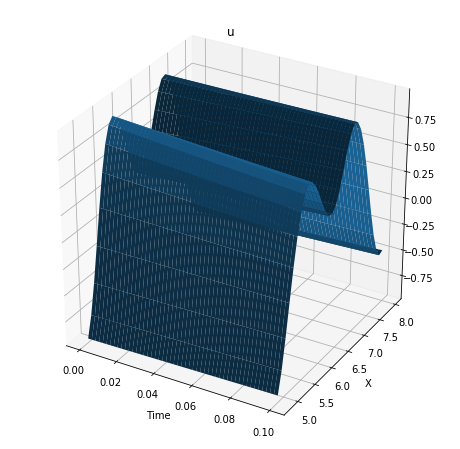

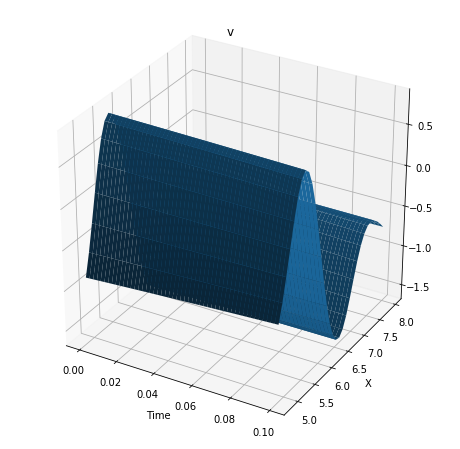

In [53]:
data_model.visualize(0)

## Energy Advanced

In [70]:
with open("config_energy_exchange_advanced.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [71]:
config

{'name': 'Advanced',
 'dt': 0.0001,
 'dx': 0.1,
 'blocks': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'kernel_size': 5,
 'max_diff_order': 2,
 'acc_order': 1,
 'n_hidden_layers': 2,
 'n_channels': 2,
 'dataname': 'Advanced',
 'viscosity': 0.1,
 'batch_size': 32,
 'channel_names': 'u,v',
 'data_timescheme': 'rk4',
 'data_dir': '/sdsd/dsds/sdsd',
 'Nt': 500,
 'Nx': 32,
 'sigma': 1,
 'sparsity': 0.005,
 'momentsparsity': 0.001,
 'epochs': 500,
 'results_dir': '/comet/results/',
 'seed': -1,
 'learning_rate': 0.02,
 'constraint': 'moment'}

In [72]:
blocks = config['blocks']
dt = config['dt']
dx = config['dx']
epochs = config['epochs']
lr = config['learning_rate']

In [73]:
model,data_model,callbacks = setenv(config)

In [74]:
##optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [75]:
for block in blocks:
    print('[PRINT] block:',block)
    if block==0:
        print('[PRINT] Warmum Stage')
    stepnum = block if block>=1 else 1
    #get the data at this time #shape [block,batch,channel,X_dim]
    u_obs = data_model.data(stepnum+1) #np array of stepnum elements
    for epoch in range(epochs):
        #zero grad
        optimizer.zero_grad()
        #forward
        loss,data_loss,syment_reg,moment_loss = modelLoss(model,u_obs,config,block)
        loss.backward()
        optimizer.step()
        if epoch%10==0:
            print("[PRINT] Epoch: %d, Loss: %.3f, Data Loss: %.3f, Symnet Regularize: %.3f, Moment Regularize: %.3f "\
                  % (epoch,loss,\
                      data_loss,syment_reg,\
                      moment_loss))

    


[PRINT] block: 0
[PRINT] Warmum Stage
[PRINT] Epoch: 0, Loss: 69.276, Data Loss: 69.273, Symnet Regularize: 13.998, Moment Regularize: 2.985 
[PRINT] Epoch: 10, Loss: 24.888, Data Loss: 24.884, Symnet Regularize: 12.442, Moment Regularize: 3.600 
[PRINT] Epoch: 20, Loss: 20.000, Data Loss: 19.996, Symnet Regularize: 14.530, Moment Regularize: 3.585 
[PRINT] Epoch: 30, Loss: 14.185, Data Loss: 14.181, Symnet Regularize: 15.614, Moment Regularize: 3.557 
[PRINT] Epoch: 40, Loss: 10.967, Data Loss: 10.963, Symnet Regularize: 16.632, Moment Regularize: 3.511 
[PRINT] Epoch: 50, Loss: 8.179, Data Loss: 8.176, Symnet Regularize: 17.701, Moment Regularize: 3.593 
[PRINT] Epoch: 60, Loss: 4.318, Data Loss: 4.315, Symnet Regularize: 18.877, Moment Regularize: 3.652 
[PRINT] Epoch: 70, Loss: 1.003, Data Loss: 1.000, Symnet Regularize: 19.794, Moment Regularize: 3.725 
[PRINT] Epoch: 80, Loss: 0.528, Data Loss: 0.525, Symnet Regularize: 20.111, Moment Regularize: 3.825 
[PRINT] Epoch: 90, Loss: 0

[PRINT] Epoch: 300, Loss: 0.095, Data Loss: 0.019, Symnet Regularize: 14.422, Moment Regularize: 3.588 
[PRINT] Epoch: 310, Loss: 0.095, Data Loss: 0.019, Symnet Regularize: 14.402, Moment Regularize: 3.581 


KeyboardInterrupt: 

In [68]:
model.all_symnets[0].getEquation(calprec=2)

-0.985807*u_1*v_1 + 0.0990048*u_2

In [69]:
model.all_symnets[1].getEquation(calprec=2)

0.984687*u_1*v_1 + 0.0993288*v_2

In [67]:
torch.save(model.state_dict(),"Energy_eqn_advan.pth")